#Trabalho 1 de Introdução à Inteligência Artificial

**Autor:**

*   Rafael Cutrim de Almeida: 242039621

**Objetivo do Projeto:**

Este projeto implementa um sistema inteligente de recomendação para uma livraria virtual que sugere livros aos usuários com base nas características dos produtos e no perfil de preferências de cada leitor.

**Funcionalidades principais:**

* Cadastro de usuários com coleta de preferências literárias

* Catálogo de 20 livros classificados por gênero, tipo (ficção/não-ficção) e nível de leitura

* Matriz de utilidade com 500 perfis de avaliações sintéticas

* Algoritmo TF-IDF para identificar características relevantes dos livros

* Cálculo de similaridade baseado no cosseno para encontrar livros compatíveis

* Recomendações personalizadas tanto por perfil do usuário quanto por livros similares

* Interface interativa para cadastro e visualização das recomendações

O sistema analisa as características dos livros e as preferências declaradas dos usuários para sugerir títulos que melhor se alinham com seus interesses literários.


#Bibliotecas utilizadas

In [53]:
!pip install streamlit plotly

In [54]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import streamlit as st
import json
import sys
import os

##Parte 1

#Base de dados:
a base de dados consiste em 21 livros de gêneros e dificuldade de leitura diferentes.

In [55]:
livros = [
    {"id": 1, "titulo": "Como Treinar seu Dragão", "genero": "aventura", "tipo": "ficcao", "nivel": "iniciante"},
    {"id": 2, "titulo": "Cujo", "genero": "horror", "tipo": "ficcao", "nivel": "intermediario"},
    {"id": 3, "titulo": "Percy Jackson", "genero": "fantasia", "tipo": "ficcao", "nivel": "iniciante"},
    {"id": 4, "titulo": "Hora Morta", "genero": "suspense", "tipo": "ficcao", "nivel": "intermediario"},
    {"id": 5, "titulo": "Call Of Cthulhu", "genero": "horror_cosmico", "tipo": "ficcao", "nivel": "avancado"},
    {"id": 6, "titulo": "Diário de um Banana", "genero": "comedia", "tipo": "ficcao", "nivel": "iniciante"},
    {"id": 7, "titulo": "Harry Potter", "genero": "fantasia", "tipo": "ficcao", "nivel": "intermediario"},
    {"id": 8, "titulo": "Senhor dos Aneis", "genero": "fantasia", "tipo": "ficcao", "nivel": "avancado"},
    {"id": 9, "titulo": "Game of Thrones", "genero": "fantasia_epica", "tipo": "ficcao", "nivel": "avancado"},
    {"id": 10, "titulo": "The Witcher", "genero": "fantasia", "tipo": "ficcao", "nivel": "intermediario"},
    {"id": 11, "titulo": "Death Note", "genero": "suspense_sobrenatural", "tipo": "ficcao", "nivel": "intermediario"},
    {"id": 12, "titulo": "Dan Dan Dan", "genero": "terror", "tipo": "ficcao", "nivel": "intermediario"},
    {"id": 13, "titulo": "1984", "genero": "distopia", "tipo": "ficcao", "nivel": "avancado"},
    {"id": 14, "titulo": "A revolução dos bichos", "genero": "distopia", "tipo": "ficcao", "nivel": "intermediario"},
    {"id": 15, "titulo": "O auto da compadecida", "genero": "comedia", "tipo": "ficcao", "nivel": "intermediario"},
    {"id": 16, "titulo": "Memórias Póstumas de Brás Cubas", "genero": "classico", "tipo": "ficcao", "nivel": "avancado"},
    {"id": 17, "titulo": "Cálculo 1", "genero": "matematica", "tipo": "nao_ficcao", "nivel": "avancado"},
    {"id": 18, "titulo": "O Programador Pragmático", "genero": "tecnologia", "tipo": "nao_ficcao", "nivel": "intermediario"},
    {"id": 19, "titulo": "A morte e a vida de Alan Turing", "genero": "biografia", "tipo": "nao_ficcao", "nivel": "avancado"},
    {"id": 20, "titulo": "O Iluminado", "genero": "horror", "tipo": "ficcao", "nivel": "avancado"},
    {"id": 21, "titulo": "IT: A coisa", "genero": "horror", "tipo": "ficcao", "nivel": "avancado"}
]

#Sistema de avaliação

* ⭐ (1) - Não gostei - Abandonei a leitura ou não aproveitei

* ⭐⭐ (2) - Gostei pouco - Terminei mas não foi uma boa experiência

* ⭐⭐⭐ (3) - Gostei moderadamente - Leitura agradável, mas sem grande impacto

* ⭐⭐⭐⭐ (4) - Gostei muito - Livro muito bom, recomendo para outros

* ⭐⭐⭐⭐⭐ (5) - Adorei - Obra excepcional, marcante, releria

##Parte 2

#Organização e formatação de dados:

In [56]:
np.random.seed(42)
n_usuarios = 500
n_livros = 21
df_livros = pd.DataFrame(livros)
print("📚 Catálogo de Livros:")
print(df_livros[['titulo', 'genero', 'tipo', 'nivel']])
print("\n" + "="*80 + "\n")

📚 Catálogo de Livros:
                             titulo                 genero        tipo  \
0           Como Treinar seu Dragão               aventura      ficcao   
1                              Cujo                 horror      ficcao   
2                     Percy Jackson               fantasia      ficcao   
3                        Hora Morta               suspense      ficcao   
4                   Call Of Cthulhu         horror_cosmico      ficcao   
5               Diário de um Banana                comedia      ficcao   
6                      Harry Potter               fantasia      ficcao   
7                  Senhor dos Aneis               fantasia      ficcao   
8                   Game of Thrones         fantasia_epica      ficcao   
9                       The Witcher               fantasia      ficcao   
10                       Death Note  suspense_sobrenatural      ficcao   
11                      Dan Dan Dan                 terror      ficcao   
12              

#Criação da matriz de utilidade com padrões aleatórios


In [57]:
#Função que gera a matriz de utilidade
def gerar_matriz_utilidade(n_usuarios, livros):
    """
    Gera matriz de utilidade com padrões realistas de avaliação
    baseados nas características dos livros
    """
    matriz = pd.DataFrame(index=range(n_usuarios),
                         columns=[f"Livro_{i+1}" for i in range(len(livros))])

    # Inicializar com zeros explicitamente
    for col in matriz.columns:
        matriz[col] = 0

    # Definir perfis de usuários baseados em preferências
    perfis_usuarios = [
        {"preferencia": "fantasia", "tipo": "ficcao", "nivel": "iniciante", "avaliacao_base": 4},
        {"preferencia": "horror", "tipo": "ficcao", "nivel": "avancado", "avaliacao_base": 5},
        {"preferencia": "comedia", "tipo": "ficcao", "nivel": "intermediario", "avaliacao_base": 4},
        {"preferencia": "distopia", "tipo": "ficcao", "nivel": "avancado", "avaliacao_base": 4},
        {"preferencia": "tecnologia", "tipo": "nao_ficcao", "nivel": "intermediario", "avaliacao_base": 3},
        {"preferencia": "aventura", "tipo": "ficcao", "nivel": "iniciante", "avaliacao_base": 4},
        {"preferencia": "suspense", "tipo": "ficcao", "nivel": "intermediario", "avaliacao_base": 4},
        {"preferencia": "classico", "tipo": "ficcao", "nivel": "avancado", "avaliacao_base": 3},
        {"preferencia": "biografia", "tipo": "nao_ficcao", "nivel": "avancado", "avaliacao_base": 4}
    ]

    for usuario in range(n_usuarios):
        # Selecionar perfil aleatório para o usuário
        perfil = perfis_usuarios[np.random.randint(0, len(perfis_usuarios))]

        # Cada usuário avalia entre 8-18 livros (40-85% do catálogo)
        n_avaliacoes = np.random.randint(8, 19)
        livros_avaliados = np.random.choice(range(len(livros)), n_avaliacoes, replace=False)

        for livro_idx in livros_avaliados:
            livro = livros[livro_idx]
            nota_base = perfil["avaliacao_base"]

            # Ajustar nota baseada na compatibilidade com perfil
            if livro["genero"] == perfil["preferencia"]:
                nota_base += 1
            if livro["tipo"] == perfil["tipo"]:
                nota_base += 0.5
            if livro["nivel"] == perfil["nivel"]:
                nota_base += 0.5

            # Adicionar variação aleatória e garantir que está entre 1-5
            nota_final = max(1, min(5, int(nota_base + np.random.normal(0, 0.7))))

            matriz.loc[usuario, f"Livro_{livro_idx+1}"] = nota_final

    # Converter para tipo numérico para evitar problemas de downcasting
    for col in matriz.columns:
        matriz[col] = pd.to_numeric(matriz[col], downcast='integer')

    return matriz

# Gerar a matriz de utilidade
print("🔄 Gerando matriz de utilidade com 500 usuários...")
matriz_utilidade = gerar_matriz_utilidade(n_usuarios, livros)

print("✅ Matriz de Utilidade gerada com sucesso!")
print(f"📊 Dimensões: {matriz_utilidade.shape}")
print(f"🎯 Média de avaliações por usuário: {(matriz_utilidade > 0).sum().sum() / n_usuarios:.1f}")

🔄 Gerando matriz de utilidade com 500 usuários...
✅ Matriz de Utilidade gerada com sucesso!
📊 Dimensões: (500, 21)
🎯 Média de avaliações por usuário: 13.2


##Análise da Matriz


In [58]:
# Estatísticas da matriz de utilidade
print("📈 ESTATÍSTICAS DA MATRIZ DE UTILIDADE")
print("="*50)

total_avaliacoes = (matriz_utilidade > 0).sum().sum()
densidade = (total_avaliacoes / (n_usuarios * n_livros)) * 100

print(f"Total de avaliações: {total_avaliacoes}")
print(f"Densidade da matriz: {densidade:.2f}%")
print(f"Avaliações por usuário: {total_avaliacoes / n_usuarios:.1f}")

# Distribuição das notas
todas_notas = matriz_utilidade.values.flatten()
todas_notas = todas_notas[todas_notas > 0]  # Remover zeros (não avaliados)

print(f"\n📊 Distribuição das Notas (1-5):")
for nota in range(1, 6):
    count = (todas_notas == nota).sum()
    percentual = (count / len(todas_notas)) * 100
    print(f"⭐ {nota} estrela(s): {count:3d} avaliações ({percentual:.1f}%)")

# Livros mais populares (mais avaliados)
avaliacoes_por_livro = (matriz_utilidade > 0).sum()
print(f"\n🏆 Top 5 livros mais avaliados:")
for i, (livro, count) in enumerate(avaliacoes_por_livro.sort_values(ascending=False).head().items(), 1):
    titulo = livros[int(livro.split('_')[1])-1]['titulo']
    print(f"{i}. {titulo}: {count} avaliações")

📈 ESTATÍSTICAS DA MATRIZ DE UTILIDADE
Total de avaliações: 6584
Densidade da matriz: 62.70%
Avaliações por usuário: 13.2

📊 Distribuição das Notas (1-5):
⭐ 1 estrela(s):  43 avaliações (0.7%)
⭐ 2 estrela(s): 493 avaliações (7.5%)
⭐ 3 estrela(s): 1628 avaliações (24.7%)
⭐ 4 estrela(s): 2430 avaliações (36.9%)
⭐ 5 estrela(s): 1990 avaliações (30.2%)

🏆 Top 5 livros mais avaliados:
1. Death Note: 335 avaliações
2. O Iluminado: 333 avaliações
3. 1984: 326 avaliações
4. A revolução dos bichos: 324 avaliações
5. Dan Dan Dan: 320 avaliações


#Salvamento de dados

In [59]:
# Salvar matriz de utilidade
matriz_utilidade.to_csv('matriz_utilidade_livros.csv', index=False)
print("💾 Matriz de utilidade salva como 'matriz_utilidade_livros.csv'")

# Salvar catálogo de livros
df_livros.to_csv('catalogo_livros.csv', index=False)
print("💾 Catálogo de livros salvo como 'catalogo_livros.csv'")

# Salvar dados em JSON para interface web
dados_completos = {
    'livros': livros,
    'matriz_utilidade': matriz_utilidade.astype(int).to_dict(),  # Converter para int para evitar problemas
    'estatisticas': {
        'total_usuarios': n_usuarios,
        'total_livros': n_livros,
        'total_avaliacoes': int(total_avaliacoes),
        'densidade': float(densidade)
    }
}

with open('dados_recomendacao.json', 'w', encoding='utf-8') as f:
    json.dump(dados_completos, f, ensure_ascii=False, indent=2)
print("💾 Dados completos salvos como 'dados_recomendacao.json'")

# Verificação final
print("\n" + "="*60)
print("✅ DADOS ORGANIZADOS E FORMATADOS COM SUCESSO!")
print("="*60)
print(f"📚 {len(livros)} livros no catálogo")
print(f"👥 {n_usuarios} usuários na matriz")
print(f"⭐ {total_avaliacoes} avaliações totais")
print(f"📊 Densidade: {densidade:.1f}%")

💾 Matriz de utilidade salva como 'matriz_utilidade_livros.csv'
💾 Catálogo de livros salvo como 'catalogo_livros.csv'
💾 Dados completos salvos como 'dados_recomendacao.json'

✅ DADOS ORGANIZADOS E FORMATADOS COM SUCESSO!
📚 21 livros no catálogo
👥 500 usuários na matriz
⭐ 6584 avaliações totais
📊 Densidade: 62.7%


#Visualização fácil dos dados

In [60]:
# Mostrar primeiras linhas da matriz
print("\n🔍 PRIMEIRAS 10 LINHAS DA MATRIZ:")
print(matriz_utilidade.head(10))

# Mostrar primeiras 5 colunas para melhor visualização
print("\n📋 PRIMEIRAS 5 COLUNAS DA MATRIZ:")
print(matriz_utilidade.iloc[:, :5].head(10))

# Verificar tipos de dados
print("\n🔧 TIPOS DE DADOS DA MATRIZ:")
print(matriz_utilidade.dtypes)


🔍 PRIMEIRAS 10 LINHAS DA MATRIZ:
   Livro_1  Livro_2  Livro_3  Livro_4  Livro_5  Livro_6  Livro_7  Livro_8  \
0        3        4        4        0        0        5        0        0   
1        3        0        4        0        0        2        0        5   
2        0        5        4        5        5        5        0        0   
3        0        4        0        2        0        3        0        3   
4        0        5        5        4        4        5        0        5   
5        4        3        0        0        3        0        5        5   
6        0        0        0        0        5        5        3        4   
7        0        4        0        0        4        5        5        5   
8        0        0        4        4        4        5        4        0   
9        3        3        0        0        0        0        0        4   

   Livro_9  Livro_10  ...  Livro_12  Livro_13  Livro_14  Livro_15  Livro_16  \
0        4         3  ...         5    

#Modelo de recomendação baseado em TF-IDF

In [61]:
# Carregar dados salvos
print("📂 Carregando dados...")
df_livros = pd.read_csv('catalogo_livros.csv')
matriz_utilidade = pd.read_csv('matriz_utilidade_livros.csv')

print("✅ Dados carregados com sucesso!")
print(f"📚 Livros: {len(df_livros)}")
print(f"👥 Usuários na matriz: {len(matriz_utilidade)}")

📂 Carregando dados...
✅ Dados carregados com sucesso!
📚 Livros: 21
👥 Usuários na matriz: 500


#Preparação dos dados por TF-IDF

In [62]:
class SistemaRecomendacaoLivros:
    def __init__(self, df_livros):
        self.df_livros = df_livros
        self.vectorizer = TfidfVectorizer()
        self.matriz_tfidf = None
        self._preparar_dados_tfidf()

    def _preparar_dados_tfidf(self):
        """Prepara os dados e calcula a matriz TF-IDF"""
        # Combinar características em um único texto para TF-IDF
        self.df_livros['caracteristicas'] = (
            self.df_livros['genero'] + " " +
            self.df_livros['tipo'] + " " +
            self.df_livros['nivel']
        )

        # Aplicar TF-IDF
        self.matriz_tfidf = self.vectorizer.fit_transform(self.df_livros['caracteristicas'])

        print("✅ Matriz TF-IDF calculada com sucesso!")
        print(f"📊 Dimensões da matriz TF-IDF: {self.matriz_tfidf.shape}")

        # Mostrar vocabulário
        feature_names = self.vectorizer.get_feature_names_out()
        print(f"🔤 Features extraídas: {len(feature_names)} termos")
        print(f"📝 Vocabulário: {list(feature_names)}")

    def analisar_features_importantes(self):
        """Analisa as features mais importantes para cada livro"""
        print("\n🔍 ANALISANDO FEATURES MAIS IMPORTANTES POR LIVRO")
        print("="*60)

        feature_names = self.vectorizer.get_feature_names_out()

        for idx, livro in self.df_livros.iterrows():
            # Obter scores TF-IDF para este livro
            feature_scores = self.matriz_tfidf[idx].toarray()[0]

            # Encontrar features com score > 0
            features_importantes = []
            for i, score in enumerate(feature_scores):
                if score > 0:
                    features_importantes.append((feature_names[i], round(score, 3)))

            # Ordenar por score
            features_importantes.sort(key=lambda x: x[1], reverse=True)

            print(f"\n📖 {livro['titulo']}:")
            for feature, score in features_importantes:
                print(f"   - {feature}: {score}")

    def recomendar_por_perfil(self, genero_preferido, tipo_preferido, nivel_preferido, top_n=5):
        """Recomenda livros baseado no perfil do usuário"""
        perfil_usuario = f"{genero_preferido} {tipo_preferido} {nivel_preferido}"

        # Transformar perfil em vetor TF-IDF
        perfil_vec = self.vectorizer.transform([perfil_usuario])

        # Calcular similaridade do cosseno
        similaridades = cosine_similarity(perfil_vec, self.matriz_tfidf)

        # Ordenar por similaridade
        indices_ordenados = similaridades.argsort()[0][::-1]

        recomendacoes = []
        for idx in indices_ordenados[:top_n]:
            livro = self.df_livros.iloc[idx]
            similaridade = similaridades[0][idx]
            recomendacoes.append({
                'id': livro['id'],
                'titulo': livro['titulo'],
                'genero': livro['genero'],
                'tipo': livro['tipo'],
                'nivel': livro['nivel'],
                'score_similaridade': round(similaridade, 3)
            })

        return recomendacoes

    def recomendar_por_livro(self, livro_id, top_n=5):
        """Recomenda livros similares a um livro específico"""
        livro_idx = livro_id - 1  # IDs começam em 1, índices em 0

        if livro_idx < 0 or livro_idx >= len(self.df_livros):
            raise ValueError("ID do livro inválido")

        # Calcular similaridade com todos os outros livros
        similaridades = cosine_similarity(
            self.matriz_tfidf[livro_idx:livro_idx+1],
            self.matriz_tfidf
        )

        # Ordenar por similaridade (excluindo o próprio livro)
        indices_ordenados = similaridades.argsort()[0][::-1]
        indices_ordenados = [i for i in indices_ordenados if i != livro_idx][:top_n]

        recomendacoes = []
        for idx in indices_ordenados:
            livro = self.df_livros.iloc[idx]
            similaridade = similaridades[0][idx]
            recomendacoes.append({
                'id': livro['id'],
                'titulo': livro['titulo'],
                'genero': livro['genero'],
                'tipo': livro['tipo'],
                'nivel': livro['nivel'],
                'score_similaridade': round(similaridade, 3)
            })

        return recomendacoes

    def visualizar_matriz_similaridade(self):
        """Visualiza a matriz de similaridade entre livros"""
        # Calcular matriz de similaridade completa
        matriz_similaridade = cosine_similarity(self.matriz_tfidf)

        # Criar heatmap
        plt.figure(figsize=(15, 12))
        sns.heatmap(matriz_similaridade,
                   xticklabels=self.df_livros['titulo'].str[:15],  # Nomes abreviados
                   yticklabels=self.df_livros['titulo'].str[:15],
                   cmap='YlOrRd',
                   annot=False,
                   cbar_kws={'label': 'Similaridade'})

        plt.title('Matriz de Similaridade entre Livros (TF-IDF + Cosseno)', fontsize=14, pad=20)
        plt.xlabel('Livros')
        plt.ylabel('Livros')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('matriz_similaridade.png', dpi=300, bbox_inches='tight')
        plt.show()

        return matriz_similaridade

# Instanciar o sistema de recomendação
print("\n🚀 Inicializando sistema de recomendação...")
sistema = SistemaRecomendacaoLivros(df_livros)


🚀 Inicializando sistema de recomendação...
✅ Matriz TF-IDF calculada com sucesso!
📊 Dimensões da matriz TF-IDF: (21, 19)
🔤 Features extraídas: 19 termos
📝 Vocabulário: ['avancado', 'aventura', 'biografia', 'classico', 'comedia', 'distopia', 'fantasia', 'fantasia_epica', 'ficcao', 'horror', 'horror_cosmico', 'iniciante', 'intermediario', 'matematica', 'nao_ficcao', 'suspense', 'suspense_sobrenatural', 'tecnologia', 'terror']


#Análise da TF-IDF

In [63]:
sistema.analisar_features_importantes()


🔍 ANALISANDO FEATURES MAIS IMPORTANTES POR LIVRO

📖 Como Treinar seu Dragão:
   - aventura: 0.756
   - iniciante: 0.602
   - ficcao: 0.255

📖 Cujo:
   - horror: 0.786
   - intermediario: 0.52
   - ficcao: 0.333

📖 Percy Jackson:
   - iniciante: 0.703
   - fantasia: 0.645
   - ficcao: 0.298

📖 Hora Morta:
   - suspense: 0.848
   - intermediario: 0.446
   - ficcao: 0.286

📖 Call Of Cthulhu:
   - horror_cosmico: 0.848
   - avancado: 0.446
   - ficcao: 0.286

📖 Diário de um Banana:
   - comedia: 0.714
   - iniciante: 0.645
   - ficcao: 0.273

📖 Harry Potter:
   - fantasia: 0.76
   - intermediario: 0.547
   - ficcao: 0.351

📖 Senhor dos Aneis:
   - fantasia: 0.76
   - avancado: 0.547
   - ficcao: 0.351

📖 Game of Thrones:
   - fantasia_epica: 0.848
   - avancado: 0.446
   - ficcao: 0.286

📖 The Witcher:
   - fantasia: 0.76
   - intermediario: 0.547
   - ficcao: 0.351

📖 Death Note:
   - suspense_sobrenatural: 0.848
   - intermediario: 0.446
   - ficcao: 0.286

📖 Dan Dan Dan:
   - terror: 0

#Testes

In [64]:
print("\n" + "="*70)
print("🎯 TESTE 1: RECOMENDAÇÕES POR PERFIL DE USUÁRIO")
print("="*70)

print("\n👤 PERFIL 1: Fã de Fantasia (Iniciante)")
recomendacoes1 = sistema.recomendar_por_perfil(
    genero_preferido="fantasia",
    tipo_preferido="ficcao",
    nivel_preferido="iniciante",
    top_n=5
)

for i, rec in enumerate(recomendacoes1, 1):
    print(f"{i}. {rec['titulo']}")
    print(f"   Gênero: {rec['genero']} | Tipo: {rec['tipo']} | Nível: {rec['nivel']}")
    print(f"   Score de Similaridade: {rec['score_similaridade']}")
    print()

print("\n👤 PERFIL 2: Não-Ficção Avançada")
recomendacoes2 = sistema.recomendar_por_perfil(
    genero_preferido="tecnologia",
    tipo_preferido="nao_ficcao",
    nivel_preferido="avancado",
    top_n=5
)

for i, rec in enumerate(recomendacoes2, 1):
    print(f"{i}. {rec['titulo']}")
    print(f"   Gênero: {rec['genero']} | Tipo: {rec['tipo']} | Nível: {rec['nivel']}")
    print(f"   Score de Similaridade: {rec['score_similaridade']}")
    print()

print("\n" + "="*70)
print("📚 TESTE 2: LIVROS SIMILARES")
print("="*70)

print("\n📖 LIVROS SIMILARES A 'HARRY POTTER':")
similares_hp = sistema.recomendar_por_livro(livro_id=7, top_n=5)
for i, rec in enumerate(similares_hp, 1):
    print(f"{i}. {rec['titulo']} (Similaridade: {rec['score_similaridade']})")

print("\n📖 LIVROS SIMILARES A 'CÁLCULO 1':")
similares_calc = sistema.recomendar_por_livro(livro_id=17, top_n=5)
for i, rec in enumerate(similares_calc, 1):
    print(f"{i}. {rec['titulo']} (Similaridade: {rec['score_similaridade']})")


🎯 TESTE 1: RECOMENDAÇÕES POR PERFIL DE USUÁRIO

👤 PERFIL 1: Fã de Fantasia (Iniciante)
1. Percy Jackson
   Gênero: fantasia | Tipo: ficcao | Nível: iniciante
   Score de Similaridade: 1.0

2. Senhor dos Aneis
   Gênero: fantasia | Tipo: ficcao | Nível: avancado
   Score de Similaridade: 0.595

3. The Witcher
   Gênero: fantasia | Tipo: ficcao | Nível: intermediario
   Score de Similaridade: 0.595

4. Harry Potter
   Gênero: fantasia | Tipo: ficcao | Nível: intermediario
   Score de Similaridade: 0.595

5. Diário de um Banana
   Gênero: comedia | Tipo: ficcao | Nível: iniciante
   Score de Similaridade: 0.535


👤 PERFIL 2: Não-Ficção Avançada
1. O Programador Pragmático
   Gênero: tecnologia | Tipo: nao_ficcao | Nível: intermediario
   Score de Similaridade: 0.855

2. Cálculo 1
   Gênero: matematica | Tipo: nao_ficcao | Nível: avancado
   Score de Similaridade: 0.477

3. A morte e a vida de Alan Turing
   Gênero: biografia | Tipo: nao_ficcao | Nível: avancado
   Score de Similaridade: 

#Visualização da Matriz de Similaridade


📊 Gerando visualização da matriz de similaridade...


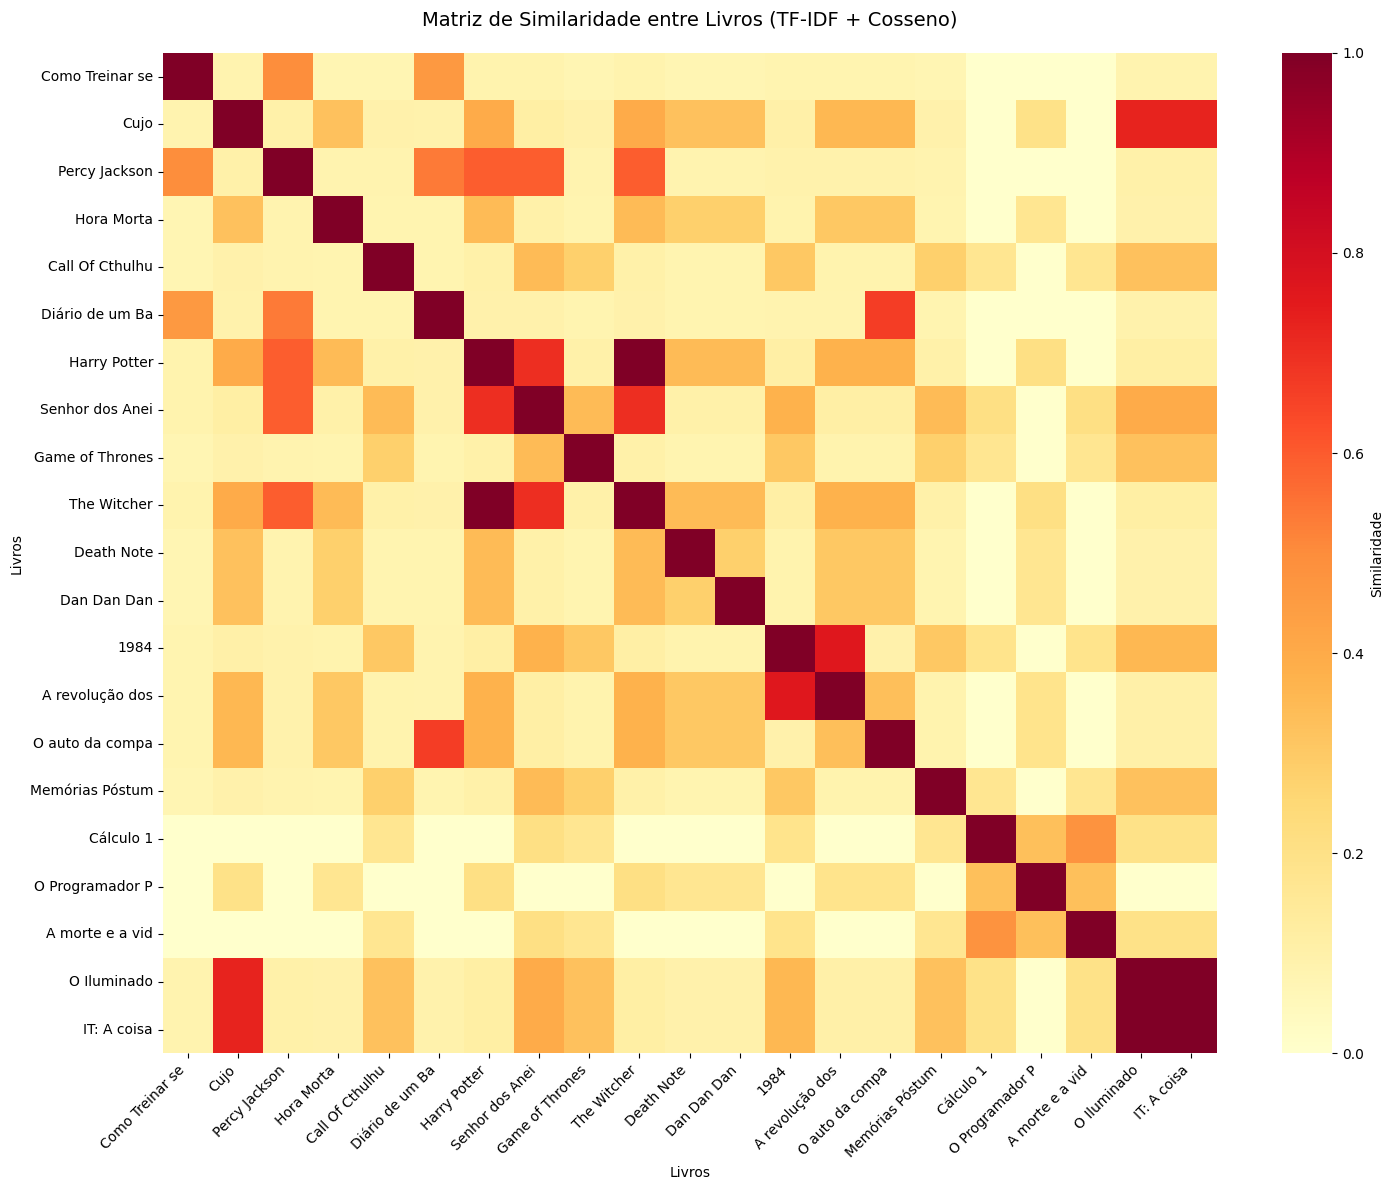

✅ Matriz de similaridade salva como 'matriz_similaridade.png'


In [65]:
print("\n📊 Gerando visualização da matriz de similaridade...")
matriz_similaridade = sistema.visualizar_matriz_similaridade()
print("✅ Matriz de similaridade salva como 'matriz_similaridade.png'")

#Análise da estatística

In [66]:
print("\n" + "="*70)
print("📈 ANÁLISE ESTATÍSTICA DO SISTEMA")
print("="*70)

# Calcular similaridades médias entre diferentes tipos
tipos_livros = df_livros['tipo'].unique()
generos_livros = df_livros['genero'].unique()

print(f"\n📋 Tipos de livros: {list(tipos_livros)}")
print(f"🎭 Gêneros de livros: {len(generos_livros)} categorias")

# Similaridade média dentro do mesmo tipo
for tipo in tipos_livros:
    indices_tipo = df_livros[df_livros['tipo'] == tipo].index
    if len(indices_tipo) > 1:
        similaridades_internas = []
        for i in indices_tipo:
            for j in indices_tipo:
                if i != j:
                    similaridades_internas.append(matriz_similaridade[i, j])

        media_similaridade = np.mean(similaridades_internas)
        print(f"📚 Similaridade média entre livros do tipo '{tipo}': {media_similaridade:.3f}")

# Salvar modelo treinado para uso futuro

modelo_data = {
    'vectorizer': sistema.vectorizer,
    'matriz_tfidf': sistema.matriz_tfidf,
    'df_livros': sistema.df_livros
}

joblib.dump(modelo_data, 'modelo_recomendacao.pkl')
print("\n💾 Modelo salvo como 'modelo_recomendacao.pkl'")

print("\n" + "="*70)
print("✅ SISTEMA DE RECOMENDAÇÃO CONCLUÍDO COM SUCESSO!")
print("="*70)
print("🎯 Funcionalidades implementadas:")
print("   • Cálculo TF-IDF das características dos livros")
print("   • Recomendações por perfil de usuário")
print("   • Recomendações por livro similar")
print("   • Visualização da matriz de similaridade")
print("   • Análise estatística do sistema")


📈 ANÁLISE ESTATÍSTICA DO SISTEMA

📋 Tipos de livros: ['ficcao', 'nao_ficcao']
🎭 Gêneros de livros: 14 categorias
📚 Similaridade média entre livros do tipo 'ficcao': 0.221
📚 Similaridade média entre livros do tipo 'nao_ficcao': 0.380

💾 Modelo salvo como 'modelo_recomendacao.pkl'

✅ SISTEMA DE RECOMENDAÇÃO CONCLUÍDO COM SUCESSO!
🎯 Funcionalidades implementadas:
   • Cálculo TF-IDF das características dos livros
   • Recomendações por perfil de usuário
   • Recomendações por livro similar
   • Visualização da matriz de similaridade
   • Análise estatística do sistema


#teste de perfis

In [67]:
# 🎯 TESTES COM DIFERENTES PERFIS DE USUÁRIOS (CORRIGIDO)

print("🧪 TESTANDO DIFERENTES PERFIS DE USUÁRIOS")
print("="*70)

# Perfil 1: JOVEM LEITOR INICIANTE
print("\n🎯 PERFIL 1: JOVEM LEITOR INICIANTE (12-15 anos)")
print("   Preferências: Aventura, Ficção, Iniciante")
print("   " + "-"*50)

recomendacoes1 = sistema.recomendar_por_perfil(
    genero_preferido="aventura",
    tipo_preferido="ficcao",
    nivel_preferido="iniciante",
    top_n=6
)

for i, rec in enumerate(recomendacoes1, 1):
    print(f"{i}. {rec['titulo']}")
    print(f"   ⭐ Score: {rec['score_similaridade']} | Gênero: {rec['genero']} | Nível: {rec['nivel']}")
    print()

# Perfil 2: FÃ DE HORROR AVANÇADO
print("\n🎯 PERFIL 2: FÃ DE HORROR EXPERIENTE")
print("   Preferências: Horror, Ficção, Avançado")
print("   " + "-"*50)

recomendacoes2 = sistema.recomendar_por_perfil(
    genero_preferido="horror",
    tipo_preferido="ficcao",
    nivel_preferido="avancado",
    top_n=6
)

for i, rec in enumerate(recomendacoes2, 1):
    print(f"{i}. {rec['titulo']}")
    print(f"   ⭐ Score: {rec['score_similaridade']} | Gênero: {rec['genero']} | Nível: {rec['nivel']}")
    print()

# Perfil 3: ESTUDANTE DE TECNOLOGIA
print("\n🎯 PERFIL 3: ESTUDANTE DE TECNOLOGIA")
print("   Preferências: Tecnologia, Não-Ficção, Intermediário")
print("   " + "-"*50)

recomendacoes3 = sistema.recomendar_por_perfil(
    genero_preferido="tecnologia",
    tipo_preferido="nao_ficcao",
    nivel_preferido="intermediario",
    top_n=6
)

for i, rec in enumerate(recomendacoes3, 1):
    print(f"{i}. {rec['titulo']}")
    print(f"   ⭐ Score: {rec['score_similaridade']} | Gênero: {rec['genero']} | Nível: {rec['nivel']}")
    print()

# Perfil 4: LEITOR CASUAL DE COMÉDIA (CORRIGIDO)
print("\n🎯 PERFIL 4: LEITOR CASUAL (COMÉDIA)")
print("   Preferências: Comédia, Ficção, Intermediário")
print("   " + "-"*50)

recomendacoes4 = sistema.recomendar_por_perfil(  # CORREÇÃO AQUI
    genero_preferido="comedia",
    tipo_preferido="ficcao",
    nivel_preferido="intermediario",
    top_n=6
)

for i, rec in enumerate(recomendacoes4, 1):
    print(f"{i}. {rec['titulo']}")
    print(f"   ⭐ Score: {rec['score_similaridade']} | Gênero: {rec['genero']} | Nível: {rec['nivel']}")
    print()

# Perfil 5: FÃ DE FANTASIA
print("\n🎯 PERFIL 5: FÃ DE FANTASIA")
print("   Preferências: Fantasia, Ficção, Intermediário")
print("   " + "-"*50)

recomendacoes5 = sistema.recomendar_por_perfil(
    genero_preferido="fantasia",
    tipo_preferido="ficcao",
    nivel_preferido="intermediario",
    top_n=6
)

for i, rec in enumerate(recomendacoes5, 1):
    print(f"{i}. {rec['titulo']}")
    print(f"   ⭐ Score: {rec['score_similaridade']} | Gênero: {rec['genero']} | Nível: {rec['nivel']}")
    print()

🧪 TESTANDO DIFERENTES PERFIS DE USUÁRIOS

🎯 PERFIL 1: JOVEM LEITOR INICIANTE (12-15 anos)
   Preferências: Aventura, Ficção, Iniciante
   --------------------------------------------------
1. Como Treinar seu Dragão
   ⭐ Score: 1.0 | Gênero: aventura | Nível: iniciante

2. Percy Jackson
   ⭐ Score: 0.5 | Gênero: fantasia | Nível: iniciante

3. Diário de um Banana
   ⭐ Score: 0.458 | Gênero: comedia | Nível: iniciante

4. Senhor dos Aneis
   ⭐ Score: 0.09 | Gênero: fantasia | Nível: avancado

5. The Witcher
   ⭐ Score: 0.09 | Gênero: fantasia | Nível: intermediario

6. Harry Potter
   ⭐ Score: 0.09 | Gênero: fantasia | Nível: intermediario


🎯 PERFIL 2: FÃ DE HORROR EXPERIENTE
   Preferências: Horror, Ficção, Avançado
   --------------------------------------------------
1. IT: A coisa
   ⭐ Score: 1.0 | Gênero: horror | Nível: avancado

2. O Iluminado
   ⭐ Score: 1.0 | Gênero: horror | Nível: avancado

3. Cujo
   ⭐ Score: 0.73 | Gênero: horror | Nível: intermediario

4. Senhor dos Aneis

In [68]:
# 🎭 TESTES ADICIONAIS COM PERFIS ESPECÍFICOS

print("\n" + "="*70)
print("🎭 TESTES COM PERFIS ESPECÍFICOS")
print("="*70)

# Perfil 6: FÃ DE DISTOPIA
print("\n🎯 PERFIL 6: FÃ DE DISTOPIA")
print("   Preferências: Distopia, Ficção, Avançado")
print("   " + "-"*50)

recomendacoes6 = sistema.recomendar_por_perfil(
    genero_preferido="distopia",
    tipo_preferido="ficcao",
    nivel_preferido="avancado",
    top_n=5
)

for i, rec in enumerate(recomendacoes6, 1):
    print(f"{i}. {rec['titulo']}")
    print(f"   ⭐ Score: {rec['score_similaridade']} | Gênero: {rec['genero']}")

# Perfil 7: INICIANTE EM LEITURA
print("\n🎯 PERFIL 7: LEITOR INICIANTE")
print("   Preferências: Vários gêneros, Ficção, Iniciante")
print("   " + "-"*50)

recomendacoes7 = sistema.recomendar_por_perfil(
    genero_preferido="aventura",  # Gênero com livros iniciantes
    tipo_preferido="ficcao",
    nivel_preferido="iniciante",
    top_n=8
)

for i, rec in enumerate(recomendacoes7, 1):
    print(f"{i}. {rec['titulo']}")
    print(f"   ⭐ Score: {rec['score_similaridade']} | Gênero: {rec['genero']} | Nível: {rec['nivel']}")


🎭 TESTES COM PERFIS ESPECÍFICOS

🎯 PERFIL 6: FÃ DE DISTOPIA
   Preferências: Distopia, Ficção, Avançado
   --------------------------------------------------
1. 1984
   ⭐ Score: 1.0 | Gênero: distopia
2. A revolução dos bichos
   ⭐ Score: 0.763 | Gênero: distopia
3. Senhor dos Aneis
   ⭐ Score: 0.376 | Gênero: fantasia
4. O Iluminado
   ⭐ Score: 0.358 | Gênero: horror
5. IT: A coisa
   ⭐ Score: 0.358 | Gênero: horror

🎯 PERFIL 7: LEITOR INICIANTE
   Preferências: Vários gêneros, Ficção, Iniciante
   --------------------------------------------------
1. Como Treinar seu Dragão
   ⭐ Score: 1.0 | Gênero: aventura | Nível: iniciante
2. Percy Jackson
   ⭐ Score: 0.5 | Gênero: fantasia | Nível: iniciante
3. Diário de um Banana
   ⭐ Score: 0.458 | Gênero: comedia | Nível: iniciante
4. Senhor dos Aneis
   ⭐ Score: 0.09 | Gênero: fantasia | Nível: avancado
5. The Witcher
   ⭐ Score: 0.09 | Gênero: fantasia | Nível: intermediario
6. Harry Potter
   ⭐ Score: 0.09 | Gênero: fantasia | Nível: inte

#Sistema de interface

In [69]:
class InterfaceRecomendacao:
    def __init__(self):
        self.carregar_dados()
        self.configurar_pagina()

    def configurar_pagina(self):
        """Configura a página do Streamlit"""
        st.set_page_config(
            page_title="Sistema de Recomendação de Livros",
            page_icon="📚",
            layout="wide",
            initial_sidebar_state="expanded"
        )

    def carregar_dados(self):
        """Carrega os dados e modelo salvos"""
        try:
            self.df_livros = pd.read_csv('catalogo_livros.csv')
            self.matriz_utilidade = pd.read_csv('matriz_utilidade_livros.csv')

            # Carregar modelo treinado
            modelo_data = joblib.load('modelo_recomendacao.pkl')
            self.vectorizer = modelo_data['vectorizer']
            self.matriz_tfidf = modelo_data['matriz_tfidf']

            st.success("✅ Dados carregados com sucesso!")
        except Exception as e:
            st.error(f"❌ Erro ao carregar dados: {e}")

    def recomendar_por_perfil(self, genero_preferido, tipo_preferido, nivel_preferido, top_n=5):
        """Função de recomendação adaptada para a interface"""
        perfil_usuario = f"{genero_preferido} {tipo_preferido} {nivel_preferido}"
        perfil_vec = self.vectorizer.transform([perfil_usuario])

        similaridades = cosine_similarity(perfil_vec, self.matriz_tfidf)
        indices_ordenados = similaridades.argsort()[0][::-1]

        recomendacoes = []
        for idx in indices_ordenados[:top_n]:
            livro = self.df_livros.iloc[idx]
            similaridade = similaridades[0][idx]
            recomendacoes.append({
                'id': livro['id'],
                'titulo': livro['titulo'],
                'genero': livro['genero'],
                'tipo': livro['tipo'],
                'nivel': livro['nivel'],
                'score_similaridade': round(similaridade, 3)
            })

        return recomendacoes

    def sidebar_cadastro(self):
        """Sidebar para cadastro e preferências do usuário"""
        st.sidebar.title("📝 Cadastro do Usuário")

        with st.sidebar.form("cadastro_usuario"):
            st.subheader("Informações Pessoais")
            nome = st.text_input("Nome completo")
            email = st.text_input("E-mail")
            idade = st.slider("Idade", 10, 80, 25)

            st.subheader("🎯 Preferências Literárias")

            genero_preferido = st.selectbox(
                "Gênero favorito",
                options=sorted(self.df_livros['genero'].unique())
            )

            tipo_preferido = st.selectbox(
                "Tipo de leitura preferido",
                options=self.df_livros['tipo'].unique()
            )

            nivel_preferido = st.selectbox(
                "Nível de leitura",
                options=self.df_livros['nivel'].unique()
            )

            # Botão de submissão
            submitted = st.form_submit_button("🎯 Obter Recomendações")

            if submitted:
                if nome and email:
                    return {
                        'nome': nome,
                        'email': email,
                        'idade': idade,
                        'genero_preferido': genero_preferido,
                        'tipo_preferido': tipo_preferido,
                        'nivel_preferido': nivel_preferido,
                        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                    }
                else:
                    st.sidebar.warning("⚠️ Por favor, preencha nome e e-mail")

        return None

    def mostrar_recomendacoes(self, perfil_usuario, recomendacoes):
        """Exibe as recomendações de forma visual"""
        st.title(f"🎉 Bem-vindo(a), {perfil_usuario['nome']}!")

        # Informações do perfil
        col1, col2, col3 = st.columns(3)
        with col1:
            st.metric("Idade", perfil_usuario['idade'])
        with col2:
            st.metric("Gênero Preferido", perfil_usuario['genero_preferido'])
        with col3:
            st.metric("Nível", perfil_usuario['nivel_preferido'])

        st.subheader("📖 Suas Recomendações Personalizadas")

        # Exibir recomendações em cards
        for i, rec in enumerate(recomendacoes, 1):
            with st.container():
                col1, col2 = st.columns([3, 1])

                with col1:
                    st.markdown(f"### {i}. {rec['titulo']}")
                    st.markdown(f"**Gênero:** {rec['genero']} | **Tipo:** {rec['tipo']} | **Nível:** {rec['nivel']}")

                with col2:
                    # Barra de progresso para o score
                    score_percent = rec['score_similaridade'] * 100
                    st.metric("Compatibilidade", f"{score_percent:.1f}%")

                st.progress(rec['score_similaridade'])
                st.markdown("---")

    def visualizar_dados(self):
        """Visualizações dos dados do sistema"""
        st.subheader("📊 Análise do Sistema")

        # Estatísticas básicas
        col1, col2, col3, col4 = st.columns(4)

        with col1:
            st.metric("Total de Livros", len(self.df_livros))
        with col2:
            st.metric("Total de Usuários", len(self.matriz_utilidade))
        with col3:
            total_avaliacoes = (self.matriz_utilidade > 0).sum().sum()
            st.metric("Avaliações", total_avaliacoes)
        with col4:
            densidade = (total_avaliacoes / (len(self.matriz_utilidade) * len(self.df_livros))) * 100
            st.metric("Densidade", f"{densidade:.1f}%")

        # Gráfico de distribuição por gênero
        fig_genero = px.bar(
            self.df_livros['genero'].value_counts().reset_index(),
            x='genero',
            y='count',
            title="Distribuição de Livros por Gênero",
            labels={'genero': 'Gênero', 'count': 'Quantidade'}
        )
        st.plotly_chart(fig_genero, use_container_width=True)

        # Gráfico de distribuição por nível
        fig_nivel = px.pie(
            self.df_livros,
            names='nivel',
            title="Distribuição por Nível de Leitura"
        )
        st.plotly_chart(fig_nivel, use_container_width=True)

    def explorar_catalogo(self):
        """Permite explorar todo o catálogo"""
        st.subheader("🔍 Explorar Catálogo Completo")

        # Filtros
        col1, col2, col3 = st.columns(3)
        with col1:
            filtro_genero = st.multiselect(
                "Filtrar por gênero",
                options=sorted(self.df_livros['genero'].unique())
            )
        with col2:
            filtro_tipo = st.multiselect(
                "Filtrar por tipo",
                options=self.df_livros['tipo'].unique()
            )
        with col3:
            filtro_nivel = st.multiselect(
                "Filtrar por nível",
                options=self.df_livros['nivel'].unique()
            )

        # Aplicar filtros
        df_filtrado = self.df_livros.copy()
        if filtro_genero:
            df_filtrado = df_filtrado[df_filtrado['genero'].isin(filtro_genero)]
        if filtro_tipo:
            df_filtrado = df_filtrado[df_filtrado['tipo'].isin(filtro_tipo)]
        if filtro_nivel:
            df_filtrado = df_filtrado[df_filtrado['nivel'].isin(filtro_nivel)]

        # Mostrar tabela
        st.dataframe(
            df_filtrado[['titulo', 'genero', 'tipo', 'nivel']],
            use_container_width=True,
            hide_index=True
        )

    def executar(self):
        """Função principal que executa a interface"""
        # Header
        st.title("📚 Sistema Inteligente de Recomendação de Livros")
        st.markdown("---")

        # Sidebar para cadastro
        perfil_usuario = self.sidebar_cadastro()

        # Abas principais
        tab1, tab2, tab3 = st.tabs(["🎯 Recomendações", "📊 Análise", "🔍 Catálogo"])

        with tab1:
            if perfil_usuario:
                # Gerar recomendações
                recomendacoes = self.recomendar_por_perfil(
                    perfil_usuario['genero_preferido'],
                    perfil_usuario['tipo_preferido'],
                    perfil_usuario['nivel_preferido'],
                    top_n=8
                )
                self.mostrar_recomendacoes(perfil_usuario, recomendacoes)
            else:
                st.info("👈 Preencha o formulário na sidebar para receber recomendações personalizadas!")

                # Exemplo de recomendações
                st.subheader("💡 Exemplo de Recomendações")
                exemplo_recomendacoes = self.recomendar_por_perfil(
                    "fantasia", "ficcao", "intermediario", top_n=3
                )
                for rec in exemplo_recomendacoes:
                    st.write(f"• **{rec['titulo']}** (Score: {rec['score_similaridade']})")

        with tab2:
            self.visualizar_dados()

        with tab3:
            self.explorar_catalogo()

# Executar a interface
if __name__ == "__main__":
    app = InterfaceRecomendacao()
    app.executar()

2025-10-15 12:37:55.196 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 12:37:55.201 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 12:37:55.207 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 12:37:55.213 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 12:37:55.216 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 12:37:55.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 12:37:55.220 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 12:37:55.227 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [70]:
# requirements.txt
"""
streamlit==1.28.0
pandas==2.0.3
numpy==1.24.3
scikit-learn==1.3.0
plotly==5.15.0
joblib==1.3.2
"""

'\nstreamlit==1.28.0\npandas==2.0.3\nnumpy==1.24.3\nscikit-learn==1.3.0\nplotly==5.15.0\njoblib==1.3.2\n'

In [71]:
# Carregar dados
@st.cache_data
def carregar_dados():
    df_livros = pd.read_csv('catalogo_livros.csv')
    modelo_data = joblib.load('modelo_recomendacao.pkl')
    return df_livros, modelo_data

def main():
    st.title("📚 Recomendador de Livros")

    df_livros, modelo_data = carregar_dados()

    # Formulário simples
    with st.form("preferencias"):
        st.subheader("Suas Preferências")

        genero = st.selectbox("Gênero favorito", df_livros['genero'].unique())
        tipo = st.selectbox("Tipo", df_livros['tipo'].unique())
        nivel = st.selectbox("Nível", df_livros['nivel'].unique())

        if st.form_submit_button("Obter Recomendações"):
            # Gerar recomendações (simplificado)
            perfil = f"{genero} {tipo} {nivel}"
            perfil_vec = modelo_data['vectorizer'].transform([perfil])
            similaridades = cosine_similarity(perfil_vec, modelo_data['matriz_tfidf'])

            top_5 = similaridades.argsort()[0][-5:][::-1]

            st.subheader("📖 Livros Recomendados:")
            for idx in top_5:
                livro = df_livros.iloc[idx]
                st.write(f"• **{livro['titulo']}**")
                st.write(f"  Gênero: {livro['genero']} | Nível: {livro['nivel']}")

if __name__ == "__main__":
    main()

2025-10-15 12:37:55.722 No runtime found, using MemoryCacheStorageManager
2025-10-15 12:37:55.728 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 12:37:55.730 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 12:37:55.731 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 12:37:55.734 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 12:37:55.735 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 12:37:55.736 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 12:37:55.737 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-15 12:37:55.740 Thread 'MainThread':